## Load Packages

In [110]:
using JuMP;
using HiGHS;
using Plots;
using ParametricOptInterface;
const POI = ParametricOptInterface;

# Risk-averse newsvendor

## Model, reformulate (as a deterministic equivalent) and solve the newsvendor problem using a risk measure (a convex combination of expectation and CVaR) instead of the expected cost.

Consider the two-stage formulation:

$$\min_{0 \leq x \leq u} cx + (1-\lambda)\mathbb{E}_d[Q(x,d)] + \lambda\rho[Q(x,d)]$$

where, 

$$Q(x,d) = \min_{y, z} \left\{ -qy -rz | y \leq d; y + z \leq x; y, z \geq 0 \right\}$$ 

We can rewrite the problem as:

$$
\begin{aligned}
    &\min && cx + (1-\lambda)\Sigma_s p_s\theta_s + \lambda(v+\Sigma_s p_s(\frac{u_s}{1-\alpha})) \\
    & st && 0 \leq x \leq u \\
        &&& y_s \leq d_s & \forall s \\
        &&& y_s+z_s \leq x& \forall s\\
        &&& y_s, z_s, u_s \geq 0& \forall s \\
        &&& u_s + v \geq -qy_s-rz_s& \forall s \\
        &&& \theta_s \geq -qy_s-rz_s& \forall s\\
\end{aligned}
$$

In [111]:
struct NewsboyData
    u::Float64
    c::Float64
    q::Float64
    r::Float64
    d::Vector{Float64}
    p::Vector{Float64}
    α::Float64
end

function get_newsboy_data(data::NewsboyData)
    u = data.u
    c = data.c
    q = data.q
    r = data.r
    d = data.d
    p = data.p
    α = data.α
    return u, c, q, r, d, p, α
end

function newsboy_optimal(data::NewsboyData, λ = 0)
    
    u, c, q, r, d, p, α = get_newsboy_data(data)
    S = length(d)
    
    model = Model(HiGHS.Optimizer)
    MOI.set(model, JuMP.MOI.Silent(), true)
    @variable(model, 0<=x<=u)
    @variable(model, v)
    @variable(model, 0<=y[s=1:S]<=d[s])
    @variable(model, 0<=z[1:S])
    @variable(model, 0<=u[1:S])
    @variable(model, θ[1:S])

    @constraint(model,[s = 1:S], y[s] + z[s] <= x)
    @constraint(model,[s = 1:S], -q*y[s]-r*z[s] <= θ[s])
    @constraint(model,[s = 1:S], -q*y[s]-r*z[s] <= u[s]+v)

    @objective(model, Min, c*x + (1-λ)*sum(p[s]θ[s] for s = 1:S) + λ*(v+sum(p[s]u[s]/(1-α) for s = 1:S)))

    optimize!(model)
    return objective_value(model), value(model[:x])
end

newsboy_optimal (generic function with 2 methods)

## For a fixed confidence level $\alpha = 0.9$, show how the first stage solution of the newsvendor varies with the risk-aversion parameter, i.e., the weight of the CVaR

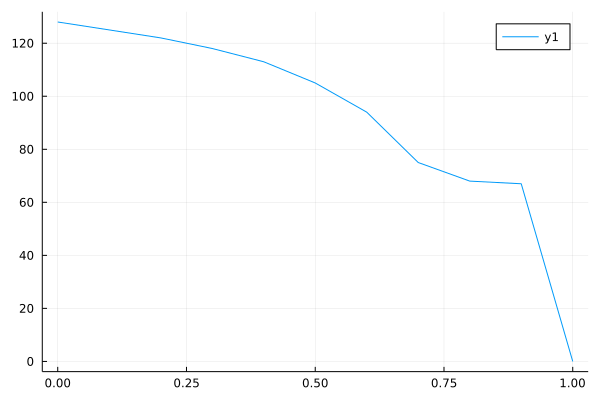

In [112]:
λ = collect(0:10)./10
X = zeros(11)
data = NewsboyData(150,10,25,5,LinRange(60,150,91),ones(91)./91, 0.9)
for i in 1:10
    _, X[i] = newsboy_optimal(data, λ[i])
end

plot(λ, X)

## Implement the Benders decomposition for the previously formulated CVaR-based newsvendor using the CVaR dual representation

In [230]:
function create_newsboy_main(data::NewsboyData, λ = 0)
    
    u, c, q, r, d, p, α = get_newsboy_data(data)
    S = length(d)
    
    main = Model(HiGHS.Optimizer)
    set_silent(main)
    @variable(main, 0<=x<=u)
    @variable(main, -1e8 <= theta[1:S])
    @variable(main, 0 <= delta[1:S])
    @variable(main, v)

    @constraint(main, [s = 1:S], delta[s] + v >= theta[s])
    
    @objective(main, Min,c*x + (1-λ)*sum(p[s]*theta[s] for s = 1:S) + λ*v + λ*(sum(p[s]*(delta[s]/(1-α)) for s = 1:S)))

    return main
end

function solve_newsboy_main(main::Model)
    
    optimize!(main)
    
    obj = objective_value(main)
    x = value(main[:x])

    return obj, x
end

function create_newsboy_subproblem(data::NewsboyData, x::Float64)
    
    u, c, q, r, d, p = get_newsboy_data(data)
    S = length(d)
    
    subproblem = Model(() -> ParametricOptInterface.Optimizer(HiGHS.Optimizer()))
    set_silent(subproblem)
    @variable(subproblem, x in ParametricOptInterface.Parameter(0))
    @variable(subproblem, demand in ParametricOptInterface.Parameter(0))
    @variable(subproblem, x_aux)
    @variable(subproblem, 0<=y)
    @variable(subproblem, 0<=z)
    
    @constraint(subproblem, y <= demand)
    @constraint(subproblem, y + z <= x_aux)
    @constraint(subproblem, dual_fisher, x_aux == x)

    @objective(subproblem, Min, -q*y-r*z)

    return subproblem
end

function solve_newsboy_subproblem(subproblem::Model, data::NewsboyData, x::Float64)
    
    u, c, q, r, d, p = get_newsboy_data(data)
    pi = zeros(length(d))
    obj = zeros(length(d))
    MOI.set(subproblem, POI.ParameterValue(), subproblem[:x], x)
    for (i, value) in enumerate(d)
        MOI.set(subproblem, POI.ParameterValue(), subproblem[:demand], value)
        optimize!(subproblem)

        obj[i] = objective_value(subproblem)
        pi[i] = -dual(subproblem[:dual_fisher])
    end
    return obj, pi
end

function CVAR(x,p,α)
    N = length(x)
    m = Model(HiGHS.Optimizer)
    set_silent(m)
    @variable(m, q[1:N] ≥ 0)
    @constraint(m, sum(q) == 1)
    @constraint(m, [s = 1:N], q[s] ≤ p[s]/(1-α))
    @objective(m, Max, sum(q.*x))
    optimize!(m)
    return objective_value(m)
end

function update_main!(main::Model, x::Float64, pi::Vector{Float64}, obj_sub::Vector{Float64})
    
    for s in 1:length(obj_sub)
        @constraint(main, main[:theta][s] >= obj_sub[s] - pi[s] * (main[:x] - x))
    end
    nothing
end

function newsboy_bender(data::NewsboyData, λ = 0)
    
    u, c, q, r, d, p, α = get_newsboy_data(data)
    S = length(d)
    
    main = create_newsboy_main(data)
    subproblem = create_newsboy_subproblem(data)
    obj_main, x = solve_newsboy_main(main)
    obj_sub, pi = solve_newsboy_subproblem(subproblem, data, x)
    
    LB = obj_main
    bar_v = sum(p[s]*obj_sub[s] for s in 1:S)
    cvar = CVAR(obj_sub,p,α)
    UB = c*x + (1-λ)*bar_v + λ*cvar
    gap = UB - LB
    while gap >= 1e-6
        update_main!(main, x, pi, obj_sub)
        obj_main, x = solve_newsboy_main(main)
        obj_sub, pi = solve_newsboy_subproblem(subproblem, data, x)
        LB = obj_main
        bar_v = sum(p[s]*obj_sub[s] for s in 1:S)
        cvar = CVAR(obj_sub,p,α)
        UB = c*x + (1-λ)*bar_v + λ*cvar
        @show gap = UB - LB
    end
    return main
end

newsboy_bender (generic function with 2 methods)

In [231]:
newsboy_bender(data, 0.1)

gap = UB - LB = 981.8881296703323
gap = UB - LB = 76.3296703296694
gap = UB - LB = 76.32967032967213
gap = UB - LB = 76.32967032967213
gap = UB - LB = 76.32967032967213
gap = UB - LB = 76.32967032967213
gap = UB - LB = 76.32967032967213
gap = UB - LB = 76.32967032967213
gap = UB - LB = 76.32967032967213
gap = UB - LB = 76.32967032967213
gap = UB - LB = 76.32967032967213
gap = UB - LB = 76.32967032967213
gap = UB - LB = 76.32967032967213
gap = UB - LB = 76.32967032967213
gap = UB - LB = 76.32967032967213
gap = UB - LB = 76.32967032967213
gap = UB - LB = 76.32967032967213
gap = UB - LB = 76.32967032967213
gap = UB - LB = 76.32967032967213
gap = UB - LB = 76.32967032967213
gap = UB - LB = 76.32967032967213
gap = UB - LB = 76.32967032967213
gap = UB - LB = 76.32967032967213
gap = UB - LB = 76.32967032967213
gap = UB - LB = 76.32967032967213
gap = UB - LB = 76.32967032967213
gap = UB - LB = 76.32967032967213
gap = UB - LB = 76.32967032967213
gap = UB - LB = 76.32967032967213
gap = UB - LB =

gap = UB - LB = 76.32967032967213
gap = UB - LB = 76.32967032967213
gap = UB - LB = 76.32967032967213
gap = UB - LB = 76.32967032967213
gap = UB - LB = 76.32967032967213
gap = UB - LB = 76.32967032967213
gap = UB - LB = 76.32967032967213
gap = UB - LB = 76.32967032967213
gap = UB - LB = 76.32967032967213
gap = UB - LB = 76.32967032967213
gap = UB - LB = 76.32967032967213
gap = UB - LB = 76.32967032967213
gap = UB - LB = 76.32967032967213
gap = UB - LB = 76.32967032967213
gap = UB - LB = 76.32967032967213
gap = UB - LB = 76.32967032967213
gap = UB - LB = 76.32967032967213
gap = UB - LB = 76.32967032967213
gap = UB - LB = 76.32967032967213
gap = UB - LB = 76.32967032967213
gap = UB - LB = 76.32967032967213
gap = UB - LB = 76.32967032967213
gap = UB - LB = 76.32967032967213
gap = UB - LB = 76.32967032967213
gap = UB - LB = 76.32967032967213
gap = UB - LB = 76.32967032967213
gap = UB - LB = 76.32967032967213
gap = UB - LB = 76.32967032967213
gap = UB - LB = 76.32967032967213
gap = UB - LB 

gap = UB - LB = 76.32967032967213
gap = UB - LB = 76.32967032967213
gap = UB - LB = 76.32967032967213
gap = UB - LB = 76.32967032967213
gap = UB - LB = 76.32967032967213
gap = UB - LB = 76.32967032967213
gap = UB - LB = 76.32967032967213
gap = UB - LB = 76.32967032967213
gap = UB - LB = 76.32967032967213
gap = UB - LB = 76.32967032967213
gap = UB - LB = 76.32967032967213
gap = UB - LB = 76.32967032967213
gap = UB - LB = 76.32967032967213
gap = UB - LB = 76.32967032967213
gap = UB - LB = 76.32967032967213
gap = UB - LB = 76.32967032967213
gap = UB - LB = 76.32967032967213
gap = UB - LB = 76.32967032967213
gap = UB - LB = 76.32967032967213
gap = UB - LB = 76.32967032967213
gap = UB - LB = 76.32967032967213
gap = UB - LB = 76.32967032967213
gap = UB - LB = 76.32967032967213
gap = UB - LB = 76.32967032967213
gap = UB - LB = 76.32967032967213
gap = UB - LB = 76.32967032967213
gap = UB - LB = 76.32967032967213
gap = UB - LB = 76.32967032967213
gap = UB - LB = 76.32967032967213
gap = UB - LB 

LoadError: InterruptException:

In [229]:
subproblem

MOI.set(subproblem, POI.ParameterValue(), subproblem[:x], 150)
MOI.set(subproblem, POI.ParameterValue(), subproblem[:demand], 150)
optimize!(subproblem)
ob = objective_value(subproblem)
df = dual(subproblem[:dual_fisher])
df

-5.0

In [216]:
    u, c, q, r, d, p = get_newsboy_data(data)
    S = length(d)
    
    subproblem = Model(() -> ParametricOptInterface.Optimizer(HiGHS.Optimizer(), evaluate_duals=true))
    set_silent(subproblem)
    @variable(subproblem, x_aux)
    @variable(subproblem, 0<=y)
    @variable(subproblem, 0<=z)
    
    @constraint(subproblem, y <= 150)
    @constraint(subproblem, y + z <= x_aux)
    @constraint(subproblem, dual_fisher, 150 == x_aux)
    @objective(subproblem, Min, -q*y-r*z)
optimize!(subproblem)
ob = objective_value(subproblem)
df = dual(subproblem[:dual_fisher])

25.0

In [194]:
ob

-3730.0